# Multiclass Classification with Chest X-rays for COVID-19

Utilizing Keras to build a CNN for classifying the images

In [1]:
import numpy as np
import pandas as pd
import PIL

import sys, glob, os
sys.path.extend(glob.glob(os.path.join(os.path.expanduser("~"), ".ivy2/jars/*.jar")))

# import findspark
# findspark.init('/home/innat/spark-2.4.0-bin-hadoop2.7')
import pyspark # pyspark library
import sparkdl # deep learning library : tensorflow backend 
from keras.applications import InceptionV3 # transfer learning using pyspark

# Just copying some stuff from this website
# https://towardsdatascience.com/transfer-learning-with-pyspark-729d49604d45
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import lit, col, struct, collect_list
from pyspark.sql.types import StringType, StructField, StructType, IntegerType, BinaryType
from functools import reduce

# Modeling
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer, readImages, DeepImagePredictor
import sparkdl as dl


Using TensorFlow backend.


## Start Spark Cluster

In [2]:
# Starting Spark Cluster
sc = SparkContext(appName = 'COVID_Classification')
spark = SparkSession(sc).builder.appName('XRayProcessing').getOrCreate()

spark

## Loading the images into SparkDF

In [3]:
# Paths for the preprocessed images
covidPath = '../images/processed/covid19'
normalPath = '../images/processed/normal'
pneumoniaPath = '../images/processed/pneumonia'

# covidPath = '../images/gray/processed/covid19/'
# normalPath = '../images/gray/processed/normal/'
# pneumoniaPath = '../images/gray/processed/pneumonia/'

# SparkDL readImages ONLY TAKES JPEG!!
normal = readImages(normalPath).withColumn('label', lit(0))
covid19 = readImages(covidPath).withColumn('label', lit(1))
pneumonia = readImages(pneumoniaPath).withColumn('label', lit(2))

dataframes = [normal, covid19, pneumonia]
# Union of the three dataframes vertically
df = reduce(lambda x, y: x.union(y), dataframes)

# Print Information on the DF
df.printSchema() 


root
 |-- filePath: string (nullable = false)
 |-- image: struct (nullable = true)
 |    |-- mode: string (nullable = false)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |-- label: integer (nullable = false)



## Turning spark df 'image.data' column into a numpy array representing the pixels

In [4]:
normal_data = np.array(normal.select('image.data').collect())
covid_data = np.array(covid19.select('image.data').collect())
pneumonia_data = np.array(pneumonia.select('image.data').collect())

In [5]:
# Reshaping the data and converting to pixels
input_list = []
label_list = []
for i in range(normal_data.shape[0]):
    temp = normal_data[i]
    curr = temp.reshape(224, 224, 3)
    input_list.append(curr)
    label_list.append(np.array([1, 0, 0]))

for i in range(covid_data.shape[0]):
    temp = covid_data[i]
    curr = temp.reshape(224, 224, 3)
    input_list.append(curr)
    label_list.append(np.array([0, 1, 0]))

for i in range(pneumonia_data.shape[0]):
    temp = pneumonia_data[i]
    curr = temp.reshape(224, 224, 3)
    input_list.append(curr)
    label_list.append(np.array([0, 0, 1]))

# Format Needed for Keras Model Input
input_data = np.array(input_list)
labels = np.array(label_list)

# As numpy arrays maybe for Dark Covid Net
# y_normal = np.zeros(normal_data.shape[0])
# y_covid = np.zeros(covid_data.shape[0]) + 1
# y_pneumonia = np.zeros(pneumonia_data.shape[0]) + 2

# labels = np.hstack((y_normal, y_covid, y_pneumonia))

In [6]:
from sklearn.model_selection import train_test_split

input_data = np.divide(input_data, 255)

X_train, X_test, y_train, y_test = train_test_split(input_data, labels, test_size = 0.2)

print('Number of Training Samples = {}'.format(X_train.shape[0]))
print('Number of Testing Samples = {}'.format(X_test.shape[0]))
print('----------------------------------')
print('Shape of Train Input = {}'.format(X_train.shape))
print('Shape of Train Labels = {}'.format(y_train.shape))

Number of Training Samples = 3192
Number of Testing Samples = 799
----------------------------------
Shape of Train Input = (3192, 224, 224, 3)
Shape of Train Labels = (3192, 3)


## Using Keras with PySpark

Keras Example from https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python

The CNN has 3 Convultional Layers.

In [53]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

from datetime import datetime

In [72]:

batch_size = 64
epochs = 100
num_classes = 3

cnn = Sequential()
cnn.add(Conv2D(8, kernel_size = (3, 3),activation = 'linear', input_shape = (224, 224, 3), padding = 'same'))
cnn.add(LeakyReLU(alpha = 0.1))
cnn.add(MaxPooling2D((2, 2), padding = 'same'))
cnn.add(Conv2D(16, (3, 3), activation = 'relu', padding = 'same'))
cnn.add(LeakyReLU(alpha = 0.1))
cnn.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
cnn.add(Conv2D(32, (3, 3), activation = 'linear', padding = 'same'))
cnn.add(LeakyReLU(alpha = 0.1))
cnn.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
cnn.add(Conv2D(16, (3, 3), activation = 'linear', padding = 'same'))
cnn.add(LeakyReLU(alpha = 0.1))
cnn.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
cnn.add(Conv2D(32, (3, 3), activation = 'linear', padding = 'same'))
cnn.add(LeakyReLU(alpha = 0.1))
cnn.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
cnn.add(Conv2D(64, (3, 3), activation = 'linear', padding = 'same'))
cnn.add(LeakyReLU(alpha = 0.1))
cnn.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
cnn.add(Conv2D(32, (3, 3), activation = 'linear', padding = 'same'))
cnn.add(LeakyReLU(alpha = 0.1))
cnn.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
cnn.add(Conv2D(64, (3, 3), activation = 'linear', padding = 'same'))
cnn.add(LeakyReLU(alpha = 0.1))
cnn.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
cnn.add(Conv2D(128, (3, 3), activation = 'linear', padding = 'same'))
cnn.add(LeakyReLU(alpha = 0.1))                  
cnn.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
cnn.add(Conv2D(64, (3, 3), activation = 'linear', padding = 'same'))
cnn.add(LeakyReLU(alpha = 0.1))
cnn.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
cnn.add(Conv2D(256, (3, 3), activation = 'linear', padding = 'same'))
cnn.add(LeakyReLU(alpha = 0.1))                  
cnn.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
cnn.add(Conv2D(128, (3, 3), activation = 'linear', padding = 'same'))
cnn.add(LeakyReLU(alpha = 0.1))                  
cnn.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
cnn.add(Conv2D(256, (3, 3), activation = 'linear', padding = 'same'))
cnn.add(LeakyReLU(alpha = 0.1))                  
cnn.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))
cnn.add(Flatten())
cnn.add(Dense(256, activation = 'relu'))
cnn.add(LeakyReLU(alpha = 0.1))
cnn.add(Dropout(0.3))            
cnn.add(Dense(3, activation = 'softmax'))

cnn.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adam(), metrics = ['accuracy'])

In [73]:
cnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_191 (Conv2D)          (None, 224, 224, 8)       224       
_________________________________________________________________
leaky_re_lu_99 (LeakyReLU)   (None, 224, 224, 8)       0         
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 112, 112, 16)      1168      
_________________________________________________________________
leaky_re_lu_100 (LeakyReLU)  (None, 112, 112, 16)      0         
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 56, 56, 32)      

In [74]:
print('Shape of X_train = {}'.format(X_train.shape))
print('Shape of y_train = {}'.format(y_train.shape))

Shape of X_train = (3192, 224, 224, 3)
Shape of y_train = (3192, 3)


In [75]:
start = datetime.now()

fit_model = cnn.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data = (X_test, y_test))

print('Time to Train = {}'.format(datetime.now() - start))

Train on 3192 samples, validate on 799 samples
Epoch 1/100
3192/3192 [==============================] - 31s 10ms/step - loss: 0.9413 - accuracy: 0.4646 - val_loss: 0.9137 - val_accuracy: 0.4656
Epoch 2/100
3192/3192 [==============================] - 29s 9ms/step - loss: 0.8759 - accuracy: 0.4646 - val_loss: 0.8736 - val_accuracy: 0.4606
Epoch 3/100
3192/3192 [==============================] - 29s 9ms/step - loss: 0.8473 - accuracy: 0.4518 - val_loss: 0.8586 - val_accuracy: 0.4831
Epoch 4/100
3192/3192 [==============================] - 29s 9ms/step - loss: 0.7993 - accuracy: 0.5125 - val_loss: 0.7788 - val_accuracy: 0.7309
Epoch 5/100
3192/3192 [==============================] - 29s 9ms/step - loss: 0.6345 - accuracy: 0.7121 - val_loss: 0.6375 - val_accuracy: 0.7559
Epoch 6/100
3192/3192 [==============================] - 29s 9ms/step - loss: 0.4805 - accuracy: 0.8117 - val_loss: 0.4817 - val_accuracy: 0.8135
Epoch 7/100
3192/3192 [==============================] - 29s 9ms/step - loss

## Evaluating the Keras Model

In [76]:
test_eval = cnn.evaluate(X_test, y_test, verbose = 0)

print('Test Loss: {}'.format(test_eval[0]))
print('Test Accuracy: {}'.format(test_eval[1]))

Test Loss: 1.8147863242145772
Test Accuracy: 0.8936170339584351


### Plotting the Loss and accuracy for both Training and Testing

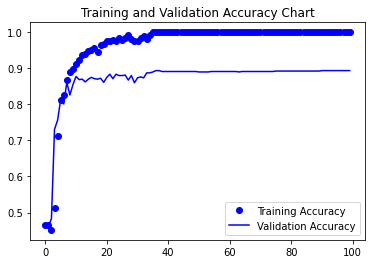

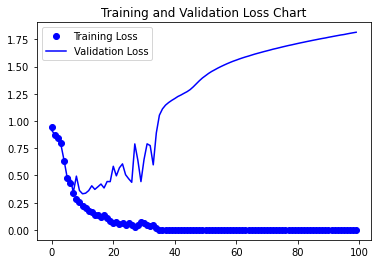

In [77]:
import matplotlib.pyplot as plt

accuracy = fit_model.history['accuracy']
val_accuracy = fit_model.history['val_accuracy']

loss = fit_model.history['loss']
val_loss = fit_model.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy Chart')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss Chart')
plt.legend()
plt.show()

## Predicting labels from Keras model

In [78]:
predicted_labels = cnn.predict(X_test)
# print(predicted_labels)

predicted_classes = np.argmax(np.round(predicted_labels), axis = 1)
# print(predicted_classes)
y_true = np.argmax(np.round(y_test), axis = 1)
# print(y_true)

In [79]:
from sklearn.metrics import classification_report

target_names = ['Normal', 'Covid-19', 'Pneumonia']
print(classification_report(y_true, predicted_classes, target_names = target_names))

              precision    recall  f1-score   support

      Normal       0.90      0.92      0.91       372
    Covid-19       0.86      0.75      0.80        65
   Pneumonia       0.90      0.89      0.89       362

    accuracy                           0.89       799
   macro avg       0.88      0.86      0.87       799
weighted avg       0.89      0.89      0.89       799



In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib as mpl

# labels = {'0': 'Normal', '1': 'Covid-19', '2': 'Pneumonia'}

# predicted_classes = predicted_classes.tolist()
# y_true = y_true.tolist()

# for i in range(len(predicted_classes)):
#     pred_ind = str(predicted_classes[i])
#     true_ind = str(y_true[i])

#     predicted_classes[i] = labels[pred_ind]
#     y_true[i] = labels[true_ind]



np.set_printoptions(threshold = np.inf) # shows whole confusion matrix
con_matrix = confusion_matrix(y_true, predicted_classes)
print(con_matrix)

# plt.matshow(con_matrix, cmap = mpl.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
# ticks = np.arange(len(con_matrix.columns))
# plt.xticks(ticks, con_matrix.columns, rotation=45)
# plt.yticks(ticks, con_matrix.index)

# plt.ylabel(df_confusion.index.name)
# plt.xlabel(df_confusion.columns.name)


[[344   1  27]
 [  6  49  10]
 [ 34   7 321]]
